# Best Performing Multi Class Supervised Classifier(Random Forest Classifier)<a id="home"></a>
## Dataset: WEB-IDS23 Dataset
#### Tasks: 
1. Improve the performance of the choosen models

#### Navigation:
1. [Import Libraries](#import-libraries)
2. [Utility Functions](#utility-functions)
3. [Load the dataset](#load-the-dataset)
4. [Preprocess the dataset](#preprocess-the-dataset)
5. [Model training](#model-training)
    1. [Model training with backward features](#backward)
    2. [Model training with forward features](#forward)
    3. [Model training with combined features](#combined)

            Author: Nithusikan T.
            Email: e19266@eng.pdn.ac.lk
            Date: 02/06/2025

#### Import Libraries  [🏠](#home) <a id="import-libraries"></a>

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score


#### Utility Functions [🏠](#home) <a id="utility-functions"></a>

In [2]:
def load_all_csv_files(folder_path):
    """
    Loads all rows from each CSV file in the folder, preserving the full
    distribution of data across files.

    Skips specific small or irrelevant files.

    Parameters:
        folder_path (str): Path to the folder containing CSV files.

    Returns:
        pd.DataFrame: Combined DataFrame with all data.
    """
    ignore_files = {
        "web-ids23_smtp_enum.csv", 
        "ssh_login.csv", 
        "ssh_login_successful.csv",
        "web-ids23_benign.csv",
        "web-ids23_bruteforce_http.csv",
        "web-ids23_bruteforce_https.csv"
    }

    all_dfs = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and filename not in ignore_files:
            file_path = os.path.join(folder_path, filename)
            try:
                df = pd.read_csv(file_path)
                all_dfs.append(df)
                print(f"{filename}: loaded {df.shape[0]} rows.")
            except Exception as e:
                print(f"Could not read {filename}: {e}")

    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

def preprocess_data(df, columns_2_drop, target_columns=['attack_type', 'attack']):
    """
    Preprocess the DataFrame by handling missing values, encoding categorical variables,
    and scaling numerical features.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    target_column (str): Name of the target variable column.
    columns_2_drop (list): List of columns to drop from the DataFrame.

    Returns:
    X (pd.DataFrame): Features DataFrame.
    y_1 (pd.Series): Target variable Series.
    y_2 (pd.Series): Second target variable Series.
    """
    # Handle missing values
    df = df.dropna(axis=0, how='any')  # Drop rows with any missing values

    # Separate features and target variable
    y_1 = df[target_columns[0]]  # attack_type
    y_2 = df[target_columns[1]]  # attack
    X = df.drop(columns=target_columns)

    # Drop some columns that are not needed for analysis
    print(f"Dropping columns: {columns_2_drop}") # df.columns[0:4])
    X = X.drop(columns=columns_2_drop)

    # Encode categorical variables if any
    X = pd.get_dummies(X, drop_first=True)

    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return pd.DataFrame(X_scaled, columns=X.columns), pd.Series(y_1), pd.Series(y_2)

def visualize_covariance_matrix(X, color="Blues"):
    """
    Visualize the covariance matrix of the features in the DataFrame.

    Parameters:
    X (pd.DataFrame): Features DataFrame.
    color (str): Color map for the heatmap.

    Returns:
    None
    """
    # plt.figure(figsize=(15, 15))
    covariance_matrix = X.cov()
    # sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap=color)
    # plt.title("Covariance Matrix")
    # # plt.show()

    return covariance_matrix


def train_and_evaluate_model(X, y, color="Blues",top_features=None, classifiers=None):
    """
    Train and evaluate multiple classifiers on the given dataset.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.
    top_features (list, optional): List of top features to select. If None, all features are used.

    Returns:
    None
    """

    # Select top features if provided
    if top_features is None:
        top_features = X.columns.tolist()  # Use all features if no specific ones are provided
    X_selected = X[top_features]

    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    trained_clfs = {}
    performance_dict = {}

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        print(f"Training {name}...")
        clf.fit(X_train, y_train)
        classifiers[name] = clf
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Print classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))

        # Store the perormance metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        performance_dict[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        }

        # Print classification report
        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix heatmap
        plt.figure(figsize=(10, 15))
        sns.heatmap(cm, annot=True, fmt='d', cmap=color,
                    xticklabels=clf.classes_, yticklabels=clf.classes_)
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return trained_clfs, performance_dict

def visualize_feature_importances(X, classifier):
    """
    Visualize feature importances for a given classifier.
    Parameters:
    X (pd.DataFrame): Features.
    classifier: The trained classifier with feature importances.
    Returns:
    None
    """
    # Visualize the feature importances for Random Forest
    plt.figure(figsize=(12, 8))
    importances = classifier.feature_importances_
    indices = importances.argsort()[::-1]
    plt.title(f"Feature Importances - {classifier.__class__.__name__}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()

def print_low_performance_classes(report, threshold=0.7):
    """
    Print classes with precision, recall, and f1-score below a specified threshold.

    Parameters:
    report (dict): Classification report from sklearn.
    threshold (float): Threshold for filtering classes.

    Returns:
    None
    """
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            precision = metrics.get('precision', 0)
            recall = metrics.get('recall', 0)
            f1_score = metrics.get('f1-score', 0)
            if precision < threshold or recall < threshold or f1_score < threshold:
                print(f"Class: {class_name}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")

def plot_feature_distribution_grid(df, features, cols=3, color="blue"):
    """
    Plot the distribution of multiple features in a grid layout.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    features (list): List of feature names to plot.
    cols (int): Number of plots per row.
    color (str): Color for the plots.
    
    Returns:
    None
    """
    num_features = len(features)
    rows = (num_features + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten in case of multi-row layout

    for i, feature in enumerate(features):
        sns.histplot(df[feature], kde=True, color=color, ax=axes[i])
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Load the dataset[🏠](#home) <a id="load-the-dataset"></a>

In [3]:
df = load_all_csv_files("E:\\Accadamics\\Semesters\\Final Year Project\\Data\\web-ids23")

web-ids23_dos_http.csv: loaded 86443 rows.
web-ids23_dos_https.csv: loaded 33216 rows.
web-ids23_ftp_login.csv: loaded 468275 rows.
web-ids23_ftp_version.csv: loaded 11688 rows.
web-ids23_hostsweep_Pn.csv: loaded 3492290 rows.
web-ids23_hostsweep_sn.csv: loaded 22637 rows.
web-ids23_portscan.csv: loaded 5046406 rows.
web-ids23_revshell_http.csv: loaded 8549 rows.
web-ids23_revshell_https.csv: loaded 9404 rows.
web-ids23_smtp_version.csv: loaded 11353 rows.
web-ids23_sql_injection_http.csv: loaded 74300 rows.
web-ids23_sql_injection_https.csv: loaded 102584 rows.
web-ids23_ssh_login.csv: loaded 34279 rows.
web-ids23_ssh_login_successful.csv: loaded 34246 rows.
web-ids23_ssrf_http.csv: loaded 5509 rows.
web-ids23_ssrf_https.csv: loaded 6656 rows.
web-ids23_xss_http.csv: loaded 4558 rows.
web-ids23_xss_https.csv: loaded 4533 rows.


### Preprocess the dataset [🏠](#home) <a id="preprocess-the-dataset"></a>

In [4]:
# Drop columns that are not needed for analysis
columns_2_drop = [
    'uid',               # Unique flow ID (not predictive)
    'ts',                # Timestamp (not useful directly; time-series analysis might use it differently)
    'id.orig_h',         # Origin IP — environment-specific
    'id.resp_h',         # Destination IP — environment-specific
    'service',           # Tool-specific, may not generalize
    'traffic_direction', # Typically derived from IPs — not generalizable
]

target_columns = ['attack_type', 'attack']  # Define target columns
X, y_attack_type, y_attack = preprocess_data(df, columns_2_drop=columns_2_drop, target_columns=target_columns)

Dropping columns: ['uid', 'ts', 'id.orig_h', 'id.resp_h', 'service', 'traffic_direction']


### Model Training [🏠](#home) <a id="model-training"></a>

In [5]:
# Define classifiers to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    # "XGBoost": XGBClassifier(use_label_encoder=False),
    # "LightGBM": LGBMClassifier()
}

#### Model training with backward features [🏠](#home) <a id="backward"></a>

Training Random Forest...

Random Forest Classification Report:
                      precision    recall  f1-score   support

            dos_http       0.87      0.91      0.89     17128
           dos_https       0.80      0.68      0.74      6693
           ftp_login       1.00      1.00      1.00     93480
       revshell_http       0.78      0.77      0.77      1588
      revshell_https       0.76      0.77      0.77      1783
  sql_injection_http       0.90      0.94      0.92     14845
 sql_injection_https       0.97      0.95      0.96     20678
           ssh_login       0.50      0.57      0.53      6739
ssh_login_successful       0.51      0.44      0.47      6934
           ssrf_http       0.67      0.68      0.67      1046
          ssrf_https       0.78      0.73      0.76      1315
            xss_http       0.61      0.63      0.62       979
           xss_https       0.55      0.59      0.57       932

            accuracy                           0.92    174140
    

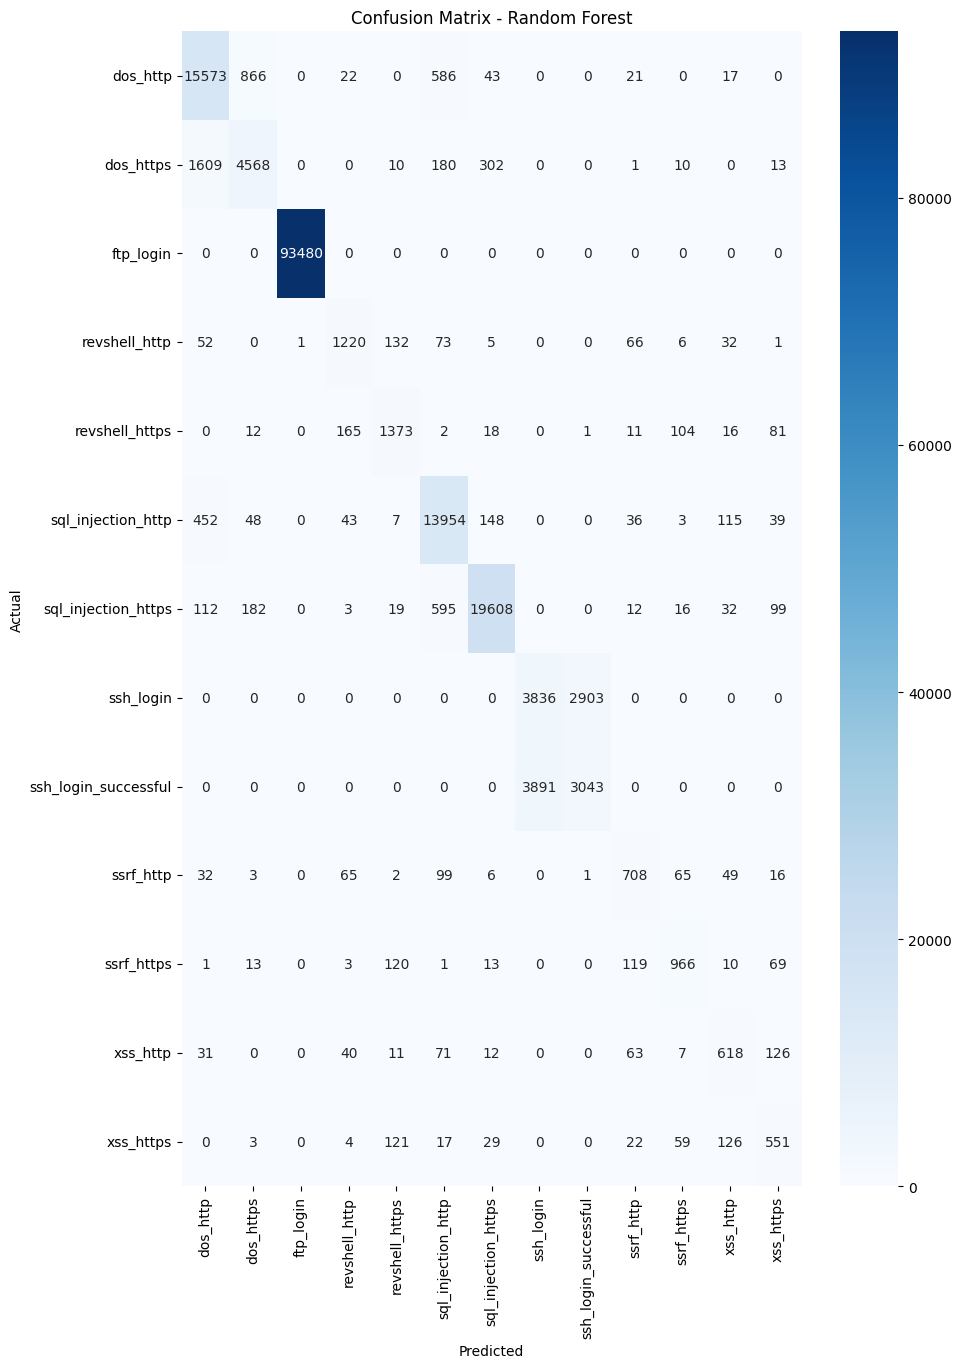

Performance Metrics:
               accuracy  f1_score  precision    recall
Random Forest  0.915918   0.91542   0.915929  0.915918


In [6]:
# Selected features based on bwd analysis and domain knowledge  
backward_features = [
    'bwd_header_size_min', 
    'fwd_header_size_max', 
    'bwd_data_pkts_tot', 
    'flow_FIN_flag_count', 
    'flow_RST_flag_count', 
    'payload_bytes_per_second', 
    'flow_duration', 
    'bwd_PSH_flag_count'
    ]

# Train and evaluate models
trained_clfs, performace_dict_1 = train_and_evaluate_model(
                    X, 
                    y_attack_type, 
                    top_features=backward_features, 
                    classifiers=classifiers
                    )

# Performance metrics
performance_df = pd.DataFrame(performace_dict_1).T
performance_df = performance_df.sort_values(by='f1_score', ascending=False)
print("Performance Metrics:")
print(performance_df)

#### Model training with forward features [🏠](#home) <a id="forward"></a>

Training Random Forest...

Random Forest Classification Report:
                      precision    recall  f1-score   support

            dos_http       0.88      0.91      0.89     17128
           dos_https       0.80      0.68      0.73      6693
           ftp_login       1.00      1.00      1.00     93480
       revshell_http       0.80      0.83      0.81      1588
      revshell_https       0.81      0.81      0.81      1783
  sql_injection_http       0.91      0.94      0.92     14845
 sql_injection_https       0.97      0.95      0.96     20678
           ssh_login       0.50      0.52      0.51      6739
ssh_login_successful       0.52      0.50      0.51      6934
           ssrf_http       0.71      0.74      0.73      1046
          ssrf_https       0.79      0.75      0.77      1315
            xss_http       0.69      0.73      0.71       979
           xss_https       0.63      0.76      0.69       932

            accuracy                           0.92    174140
    

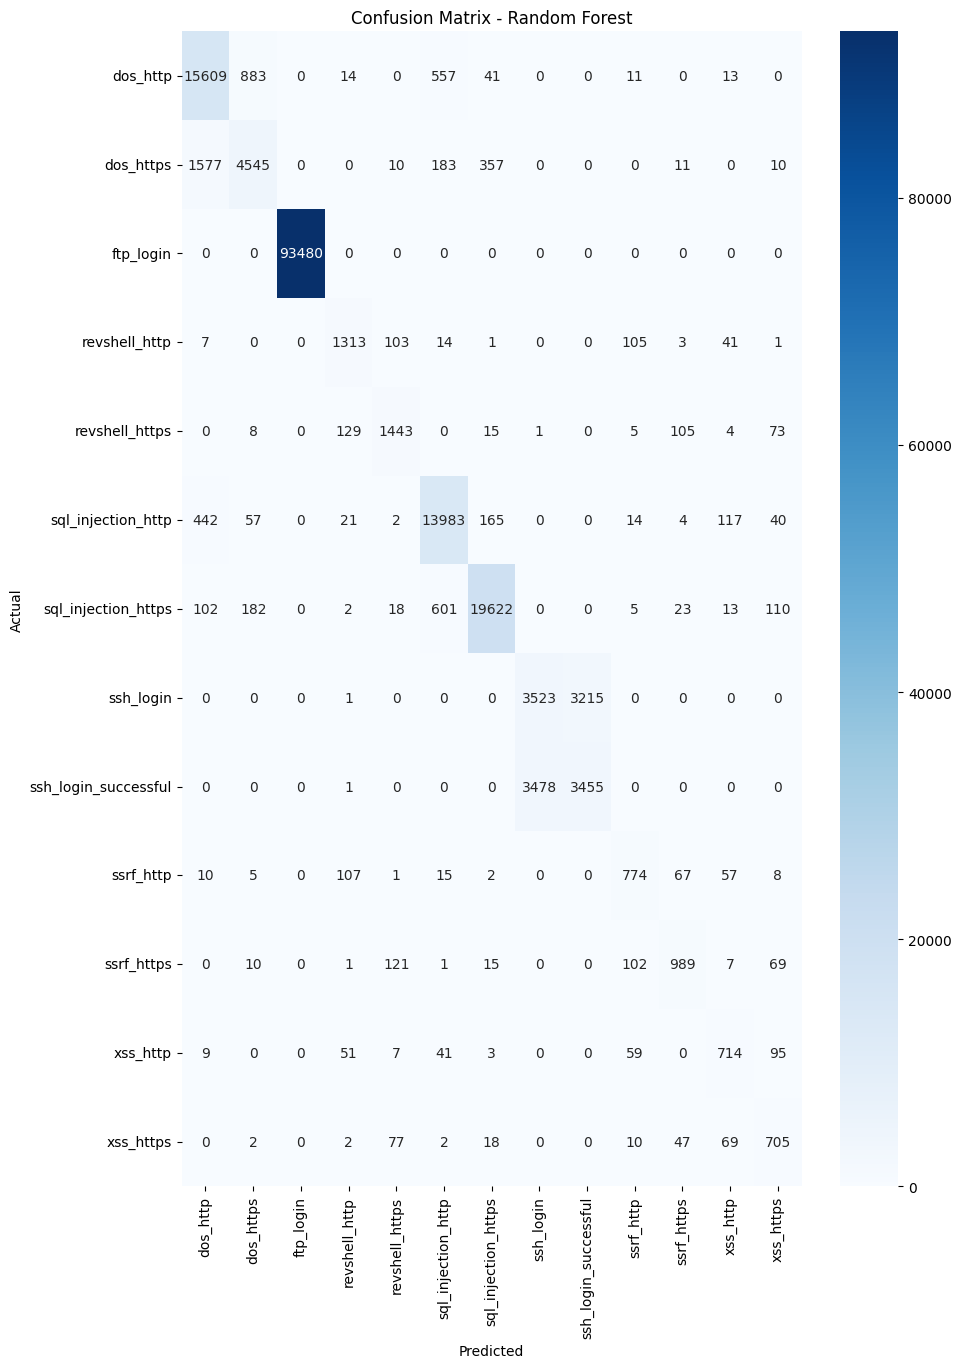

Performance Metrics:
               accuracy  f1_score  precision    recall
Random Forest  0.919691    0.9194   0.919724  0.919691


In [7]:
# Selected features from forward analysis
forward_features = [
    'flow_duration', 'bwd_data_pkts_tot', 'down_up_ratio', 
    'fwd_header_size_max', 'bwd_header_size_min', 'bwd_header_size_max', 
    'flow_FIN_flag_count', 'flow_SYN_flag_count', 'flow_RST_flag_count', 
    'fwd_PSH_flag_count', 'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'payload_bytes_per_second'
    ]

# Train and evaluate models
trained_clfs, performace_dict_1 = train_and_evaluate_model(
                    X, 
                    y_attack_type, 
                    top_features=forward_features, 
                    classifiers=classifiers
                )

# Performace metrics for forward feature model
performance_df = pd.DataFrame(performace_dict_1).T
performance_df = performance_df.sort_values(by='f1_score', ascending=False)
print("Performance Metrics:")
print(performance_df)

#### Model training with combined features [🏠](#home) <a id="combined"></a>

Training Random Forest...

Random Forest Classification Report:
                      precision    recall  f1-score   support

            dos_http       0.88      0.91      0.89     17128
           dos_https       0.80      0.68      0.73      6693
           ftp_login       1.00      1.00      1.00     93480
       revshell_http       0.80      0.82      0.81      1588
      revshell_https       0.81      0.81      0.81      1783
  sql_injection_http       0.91      0.94      0.93     14845
 sql_injection_https       0.97      0.95      0.96     20678
           ssh_login       0.50      0.53      0.52      6739
ssh_login_successful       0.52      0.49      0.50      6934
           ssrf_http       0.71      0.74      0.72      1046
          ssrf_https       0.79      0.75      0.77      1315
            xss_http       0.68      0.73      0.71       979
           xss_https       0.63      0.74      0.68       932

            accuracy                           0.92    174140
    

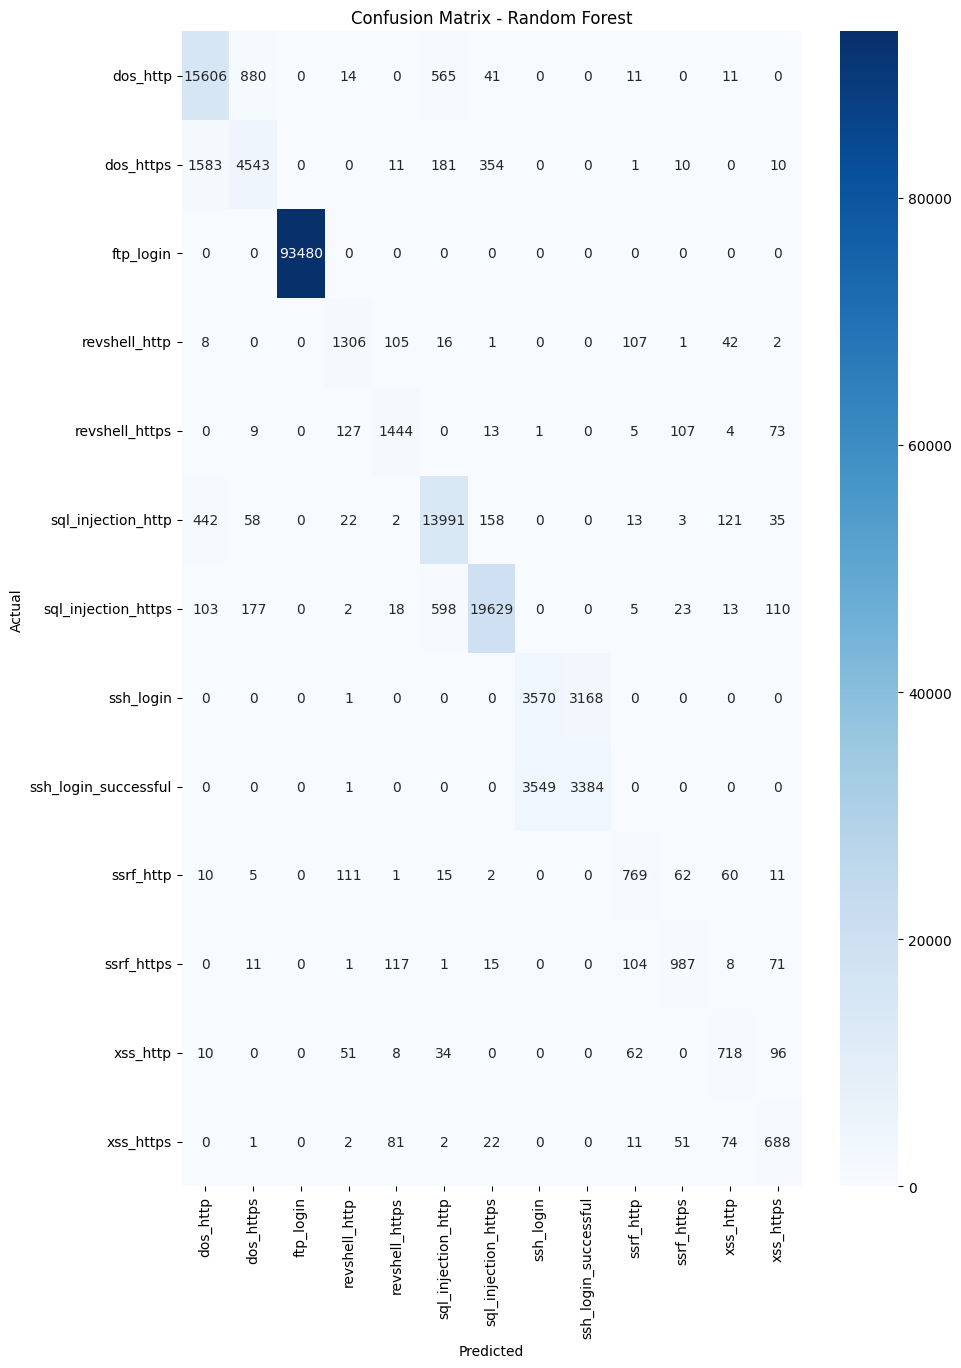

Performance Metrics:
               accuracy  f1_score  precision    recall
Random Forest  0.919461  0.919164   0.919519  0.919461


In [8]:
# Selected feature set combining both backward and forward features
combined_features = list(set(backward_features + forward_features))

# Train and evaluate models
trained_clfs, performace_dict_1 = train_and_evaluate_model(
                    X, 
                    y_attack_type, 
                    top_features=combined_features, 
                    classifiers=classifiers
                )

#Performance metrics for combined features
performance_df = pd.DataFrame(performace_dict_1).T
performance_df = performance_df.sort_values(by='f1_score', ascending=False)
print("Performance Metrics:")
print(performance_df)

### Combining http and https varients of an attack type together 

Training Random Forest...

Random Forest Classification Report:
               precision    recall  f1-score   support

          dos       0.96      0.95      0.96     23821
    ftp_login       1.00      1.00      1.00     93480
     revshell       0.87      0.85      0.86      3371
sql_injection       0.96      0.97      0.96     35523
    ssh_login       1.00      1.00      1.00     13673
         ssrf       0.81      0.79      0.80      2361
          xss       0.71      0.76      0.73      1911

     accuracy                           0.98    174140
    macro avg       0.90      0.90      0.90    174140
 weighted avg       0.98      0.98      0.98    174140

Confusion Matrix:


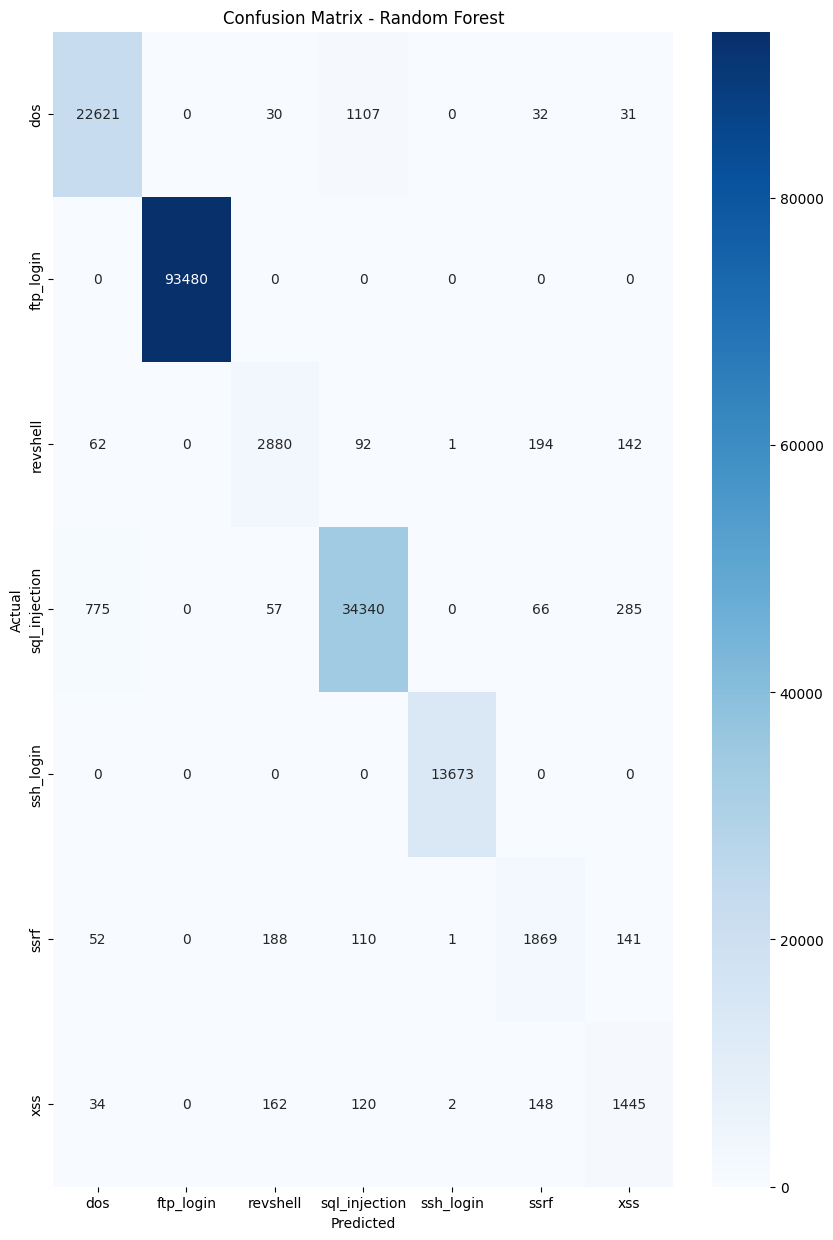

Performance Metrics:
               accuracy  f1_score  precision    recall
Random Forest  0.977995  0.978036   0.978115  0.977995


In [6]:
label_mapping = {
    'dos_http': 'dos',
    'dos_https': 'dos',
    
    'xss_http': 'xss',
    'xss_https': 'xss',
    
    'sql_injection_http': 'sql_injection',
    'sql_injection_https': 'sql_injection',
    
    'revshell_http': 'revshell',
    'revshell_https': 'revshell',
    
    'ssrf_http': 'ssrf',
    'ssrf_https': 'ssrf',
    
    'ftp_login': 'ftp_login',
    
    'ssh_login': 'ssh_login',
    'ssh_login_successful': 'ssh_login'
}

# Mapping the class labels
y_attack_type = y_attack_type.map(label_mapping)


# Selected features based on bwd analysis and domain knowledge  
backward_features = [
    'bwd_header_size_min', 
    'fwd_header_size_max', 
    'bwd_data_pkts_tot', 
    'flow_FIN_flag_count', 
    'flow_RST_flag_count', 
    'payload_bytes_per_second', 
    'flow_duration', 
    'bwd_PSH_flag_count'
    ]

# Train and evaluate models using backward features
trained_clfs, performace_dict_1 = train_and_evaluate_model(
                    X, 
                    y_attack_type, 
                    top_features=backward_features, 
                    classifiers=classifiers
                )

#Performance metrics for combined features
performance_df = pd.DataFrame(performace_dict_1).T
performance_df = performance_df.sort_values(by='f1_score', ascending=False)
print("Performance Metrics:")
print(performance_df)
